In [ ]:
#Install Kaggle
! pip install -q kaggle
#Get Api key via json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pranauv","key":"4aa4e6d6fc09f57aa04b53c2a2028901"}'}

In [ ]:
#Make a kaggle directory
! mkdir ~/.kaggle
#Copy the json file into it
! cp kaggle.json ~/.kaggle/
#Change permission of json file
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#To Read all datasets
!kaggle datasets list

In [ ]:
#To Download Data
! kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.20G/5.20G [01:51<00:00, 40.1MB/s]
100% 5.20G/5.20G [01:51<00:00, 50.2MB/s]


In [ ]:
#Unzip files
!unzip skin-cancer-mnist-ham10000.zip

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image

#Read CSV file
skin_df = pd.read_csv('/content/HAM10000_metadata.csv')

In [ ]:
#Read images based on ID from CSV
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('/content/', '*', '*.jpg'))}

In [ ]:
#Add the image path(s) to array(df) as a new column 
skin_df['path'] = skin_df['image_id'].map(image_path.get)

#Use the path(s) to read image(s) --> resize images into 32X32 --> convert images into np.array --> add them into a new column
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((32,32))))

In [ ]:
n_samples = 5
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [ ]:
np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

SIZE=32

In [ ]:
#Label encoding --> From text to numeric values
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
#Transform and Add those labels to array(skin_df) as a new column
skin_df['label']=le.transform(skin_df['dx'])

In [ ]:
#Plotting
#Data distribution visualization
#We're just looking at Cell Type(cancer type) since that's what we're gonna deal with
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

plt.tight_layout()
plt.show()

In [ ]:
#Balancing data.

#Get labels and counts --> Assign them into a new DataFrame
df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

#Resamplling those DataFrames
n_samples = 1000
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42)
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42)
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

#Combining those DataFrames to a new Single DataFrame
skin_df_balanced = pd.concat([df_0_balanced,df_1_balanced,df_2_balanced,df_3_balanced,df_4_balanced,df_5_balanced,df_6_balanced])

#Will check balanced classes
print(skin_df_balanced['label'].value_counts())

3    1000
6    1000
2    1000
5    1000
1    1000
4    1000
0    1000
Name: label, dtype: int64


In [ ]:
#Creating the X and Y for Training and Testing

#Converting 'image(s)' from DF(skin_df_balanced) to np.array
X = np.asarray(skin_df_balanced['image'].tolist())
#Sclling those values from 0-255 to 0-1.
X=X/255.

#Assigning 'label(s)' from DF(skin_df_balanced) to Y
Y=skin_df_balanced['label']
#Since this a multiclass problem we need to conver those Y values into 'categorical'
Y_cat = to_categorical(Y, num_classes=7)

#Will Split Training and Testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)


In [ ]:
#Finally, will define the model

num_calasses = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
#BatchNormalization
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation="relu"))
#BatchNormalization
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), activation="relu"))
#BatchNormalization
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation="softmax"))
model.summary()

model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["acc"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 256)       7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 128)       295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          7

In [ ]:
#Let's Train

batch_size = 16
epochs = 85

history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), verbose=2)

Epoch 1/60
329/329 - 72s - loss: 1.9052 - acc: 0.1878 - val_loss: 2.0572 - val_acc: 0.2326
Epoch 2/60
329/329 - 54s - loss: 1.7477 - acc: 0.2722 - val_loss: 1.6678 - val_acc: 0.3154
Epoch 3/60
329/329 - 54s - loss: 1.5287 - acc: 0.3851 - val_loss: 1.4280 - val_acc: 0.4223
Epoch 4/60
329/329 - 54s - loss: 1.3640 - acc: 0.4678 - val_loss: 1.2982 - val_acc: 0.4903
Epoch 5/60
329/329 - 54s - loss: 1.3172 - acc: 0.4817 - val_loss: 1.3238 - val_acc: 0.4457
Epoch 6/60
329/329 - 54s - loss: 1.2501 - acc: 0.4994 - val_loss: 1.3504 - val_acc: 0.4691
Epoch 7/60
329/329 - 54s - loss: 1.2233 - acc: 0.5269 - val_loss: 1.2547 - val_acc: 0.5034
Epoch 8/60
329/329 - 54s - loss: 1.1898 - acc: 0.5371 - val_loss: 1.1726 - val_acc: 0.5434
Epoch 9/60
329/329 - 54s - loss: 1.1546 - acc: 0.5491 - val_loss: 1.1153 - val_acc: 0.5731
Epoch 10/60
329/329 - 54s - loss: 1.1381 - acc: 0.5549 - val_loss: 1.0717 - val_acc: 0.5851
Epoch 11/60
329/329 - 54s - loss: 1.0872 - acc: 0.5735 - val_loss: 1.0374 - val_acc: 0.60

In [ ]:
#The Final Score
score = model.evaluate(x_test, y_test)
print('Test Accuracy:', score[1])

55/55 [==============================] - 0s 5ms/step - loss: 0.4704 - acc: 0.8691
Test Accuracy: 0.8691428303718567


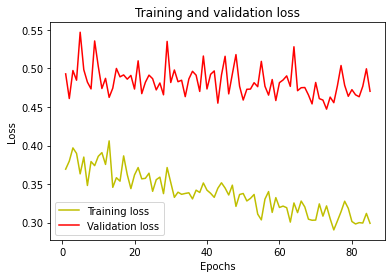

In [ ]:
#Plotting
#plot the training and validation loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

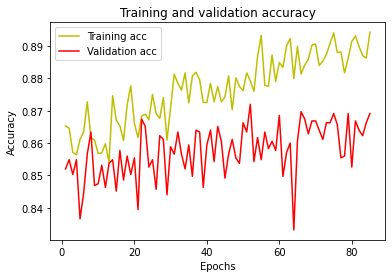

In [ ]:
#Plotting
#plot the training and validation accuracy at each epoch
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

Text(0, 0.5, 'Fraction of incorrect predictions')

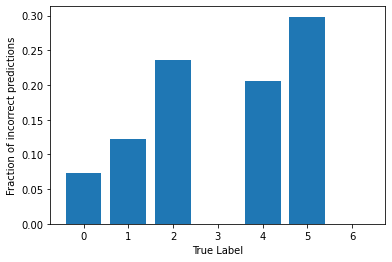

In [ ]:
#Plot fractional incorrect misclassifications
cm = confusion_matrix(y_true, y_pred_classes)
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')

In [ ]:
#Saving the model

model.save('skinCancer.h5')

In [ ]:
#Download the model

files.download('skinCancer.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Future Trainig
#Saving the model for future training
tf.keras.models.save_model()

#Load the model
tf.keras.models.load_model()